In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import parallelproj
from scipy.ndimage import gaussian_filter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


              -  -  -  -  -  -  -  -   -  -  -  -
              P  A  R  A  L  L  E  L | P  R  O  J
              -  -  -  -  -  -  -  -   -  -  -  -


             Please consider citing our publication
          ---------------------------------------------
          Georg Schramm and Kris Thielemans:
          "PARALLELPROJ—an open-source framework for
           fast calculation of projections in
           tomography"
          Front. Nucl. Med., 08 January 2024
          Sec. PET and SPECT, Vol 3
          https://doi.org/10.3389/fnume.2023.1324562

 
        parallelproj C    lib         ..: C:\Users\melis\anaconda3\envs\parallelproj-env\Library\bin\parallelproj_c.dll
        parallelproj CUDA lib         ..: None
        parallelproj CUDA kernel file ..: None
        parallelproj CUDA present     ..: False
        parallelproj cupy enabled     ..: False
        


In [3]:
#Set Random Seed for Reproducibility 
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_random_seed(1)

In [4]:

# Image size
img_size = (128, 128)

def generate_anatomy(shape=img_size, num_ellipsoids=4, min_dist=0.3):
    img = torch.zeros(shape, dtype=torch.float32, device=device)
    segmentation = torch.zeros(shape, dtype=torch.int32, device=device)

    grid_x, grid_y = torch.meshgrid(
        torch.linspace(-1, 1, shape[0], device=device),
        torch.linspace(-1, 1, shape[1], device=device),
        indexing="ij"
    )

    ellipse_centers = []  # Keep track of placed ellipses

    for _ in range(num_ellipsoids):
        attempts = 0
        while attempts < 10:  # Try 10 times to place a valid ellipse
            new_center = torch.tensor(
                [np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5)], device=device
            )
            radii = torch.tensor(
                [np.random.uniform(0.2, 0.4), np.random.uniform(0.2, 0.4)], device=device
            )

            # Check distance from existing ellipses
            if all(torch.norm(new_center - c) > min_dist for c in ellipse_centers):
                ellipse_centers.append(new_center)  # Store valid ellipse center
                break  # Exit while loop if valid placement found

            attempts += 1  # Try again if too close to existing ellipses

        # Generate the ellipse
        ellipse_eq = (((grid_x - new_center[0]) / radii[0]) ** 2 + ((grid_y - new_center[1]) / radii[1]) ** 2)
        ellipsoid = ellipse_eq <= 1

        # **Ensure most ellipses are soft tissue**
        tissue_type = np.random.choice(["soft", "bone", "air"], p=[0.8, 0.1, 0.1])

        if tissue_type == "soft":
            intensity = torch.rand(1, device=device) * 0.4 + 0.2  # Soft tissue range (0.2 - 0.6)
        elif tissue_type == "bone":
            intensity = torch.rand(1, device=device) * 0.4 + 0.6  # Bone range (0.6 - 1.0)
        else:  # Air
            intensity = torch.rand(1, device=device) * 0.2  # Air range (0.0 - 0.2)

        # Instead of overwriting, sum intensities in overlapping areas
        img[ellipsoid] += intensity  

    # Normalize intensities
    img = torch.clamp(img, 0, 1)

    # **Assign segmentation based on intensity:**
    segmentation[img < 0.1] = 0  # Air (lowest attenuation)
    segmentation[(img >= 0.2) & (img < 0.6)] = 1  # Soft tissue
    segmentation[img >= 0.6] = 2  # Bone (highest attenuation)

    return img, segmentation



def generate_pet_image(anatomy, ct_segmentation, num_tumors=3):
    pet_img = anatomy.clone()  
    pet_segmentation = ct_segmentation.clone()  

    shape = anatomy.shape
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(-1, 1, shape[0], device=device),
        torch.linspace(-1, 1, shape[1], device=device),
        indexing="ij"
    )

    max_intensity = torch.max(pet_img)  
    anatomy_mask = anatomy > 0

    for _ in range(num_tumors):
        valid_x, valid_y = torch.where(anatomy_mask)  # Recalculate valid tumor locations
        if valid_x.numel() == 0: continue  

        idx = np.random.randint(0, valid_x.numel())
        center = torch.tensor([(valid_x[idx].item() / shape[0]) * 2 - 1, 
                               (valid_y[idx].item() / shape[1]) * 2 - 1], device=device)
        radii = torch.tensor([np.random.uniform(0.05, 0.02), np.random.uniform(0.05, 0.02)], device=device)
        
        # Define tumor mask
        tumor = (((grid_x - center[0]) / radii[0]) ** 2 + ((grid_y - center[1]) / radii[1]) ** 2) <= 1
        tumor = tumor & anatomy_mask  # Ensure tumor stays inside anatomy

        if tumor.sum() == 0:  # If no valid placement, skip this tumor
            continue

        # Ensure tumor is the highest intensity
        tumor_intensity = max_intensity * 1.5  
        pet_img[tumor] = tumor_intensity

        # Assign segmentation label for tumors (e.g., 99)
        pet_segmentation[tumor] = 99  

    return torch.clamp(pet_img, 0, 1), pet_segmentation  



# Function to generate attenuation map from segmentation
def generate_attenuation_map(ct_image, segmentation):
    mu_soft_tissue = 0.02  
    mu_bone = 0.1        
    mu_air = 0.004       

    attenuation_map = torch.zeros_like(ct_image, dtype=torch.float32, device=device)
    attenuation_map[segmentation == 1] = mu_soft_tissue  
    attenuation_map[segmentation == 2] = mu_bone        
    attenuation_map[segmentation == 0] = mu_air         

    return torch.exp(-attenuation_map * ct_image) 



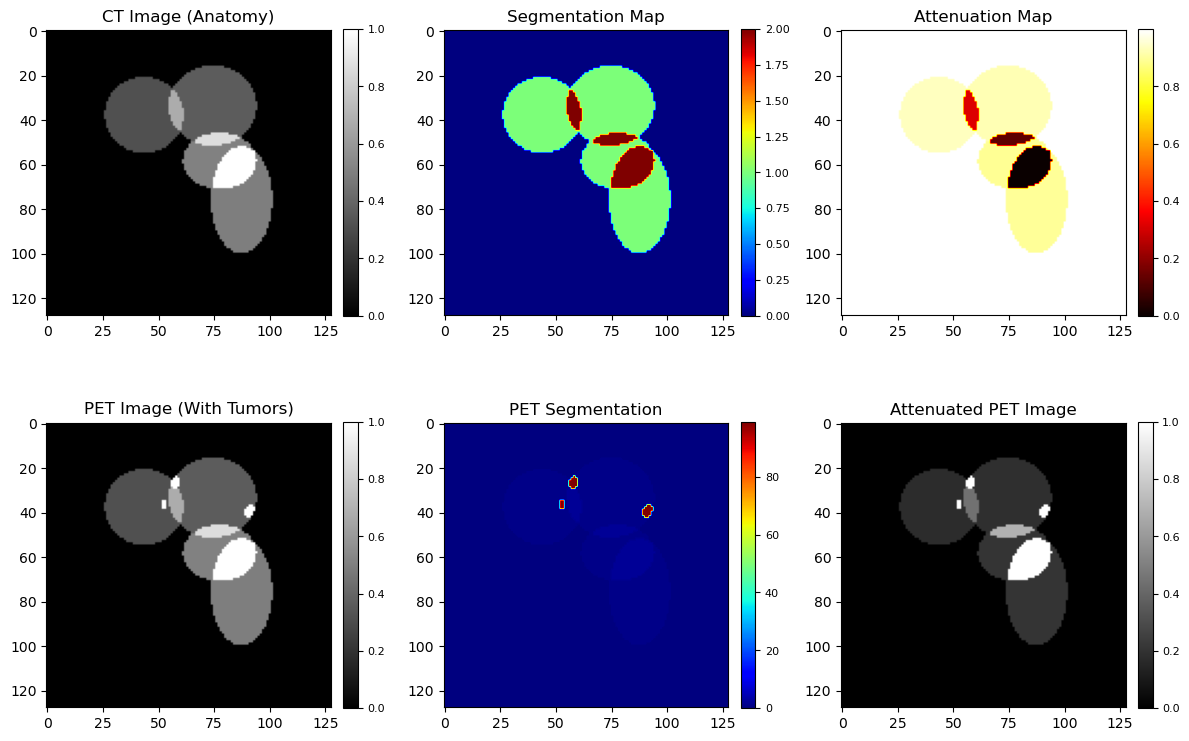

In [5]:
# Normalize function for grayscale images
def normalize(image):
    return (image - image.min()) / (image.max() - image.min() + 1e-8)  # Avoid division by zero

# Generate CT anatomy and segmentation
ct_image, ct_segmentation = generate_anatomy()
ct_image = normalize(ct_image)  # Normalize CT image

# Generate PET image with tumors
pet_image, pet_segmentation = generate_pet_image(ct_image, ct_segmentation)
pet_image = normalize(pet_image)  # Normalize PET image

# Generate attenuation map
attenuation_map = generate_attenuation_map(ct_image, ct_segmentation)
attenuation_map = normalize(attenuation_map)  # Normalize attenuation map

# Apply stronger attenuation only to non-tumor regions
stronger_attenuation_map = torch.exp( -2*attenuation_map * ct_image)
tumor_mask = (pet_segmentation == 99)  
attenuated_pet = torch.where(tumor_mask, pet_image, pet_image * stronger_attenuation_map)

# Normalize attenuated PET to ensure proper grayscale scaling
attenuated_pet = normalize(attenuated_pet)


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Function to add colorbars
def add_colorbar(im, ax):
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  # Adjust colorbar font size if needed

# Plot images with colorbars
im0 = axes[0, 0].imshow(ct_image.cpu().numpy(), cmap="gray")
axes[0, 0].set_title("CT Image (Anatomy)")
add_colorbar(im0, axes[0, 0])

im1 = axes[0, 1].imshow(ct_segmentation.cpu().numpy(), cmap="jet")
axes[0, 1].set_title("Segmentation Map")
add_colorbar(im1, axes[0, 1])

im2 = axes[0, 2].imshow(attenuation_map.cpu().numpy(), cmap="hot")
axes[0, 2].set_title("Attenuation Map")
add_colorbar(im2, axes[0, 2])

im3 = axes[1, 0].imshow(pet_image.cpu().numpy(), cmap="gray")
axes[1, 0].set_title("PET Image (With Tumors)")
add_colorbar(im3, axes[1, 0])

im4 = axes[1, 1].imshow(pet_segmentation.cpu().numpy(), cmap="jet")
axes[1, 1].set_title("PET Segmentation")
add_colorbar(im4, axes[1, 1])

im5 = axes[1, 2].imshow(attenuated_pet.cpu().numpy(), cmap="gray")
axes[1, 2].set_title("Attenuated PET Image")
add_colorbar(im5, axes[1, 2])

plt.tight_layout()
plt.show()


In [19]:

# Function to add contamination (simulating scatter & random background events)
def add_contamination(image, contamination_factor=0.1):
    if isinstance(image, np.ndarray):  # Convert NumPy array to Tensor
        image = torch.tensor(image, dtype=torch.float32, device=device)

    contamination = contamination_factor * torch.mean(image) * torch.ones_like(image)
    return image + contamination

# Function to apply Gaussian blurring (simulating scanner resolution)
def apply_blurring(image, sigma=1.5):
    image_np = image.cpu().numpy()
    blurred = gaussian_filter(image_np, sigma=sigma)  # Apply Gaussian blur
    return torch.tensor(blurred, dtype=torch.float32, device=image.device)

# Function to add Poisson noise (simulating photon counting statistics)
def add_poisson_noise(image, scale_factor=1000):
    image_np = image.cpu().numpy()
    image_scaled = image_np * scale_factor  # Scale to photon counts
    pet_noisy = np.random.poisson(image_scaled) / scale_factor  # Apply Poisson noise
    return torch.tensor(pet_noisy, dtype=torch.float32, device=image.device)

# Function to add Poisson noise to CT image
def add_poisson_noise_ct(ct_image, scale_factor=5000):
    if isinstance(ct_image, torch.Tensor):  # Convert to NumPy only if it's a tensor
        ct_image_np = ct_image.cpu().numpy()
    else:
        ct_image_np = ct_image  # Already a NumPy array
    
    ct_image_scaled = ct_image_np * scale_factor  
    ct_noisy = np.random.poisson(ct_image_scaled) / scale_factor  

    return torch.tensor(ct_noisy, dtype=torch.float32, device="cuda" if torch.cuda.is_available() else "cpu")





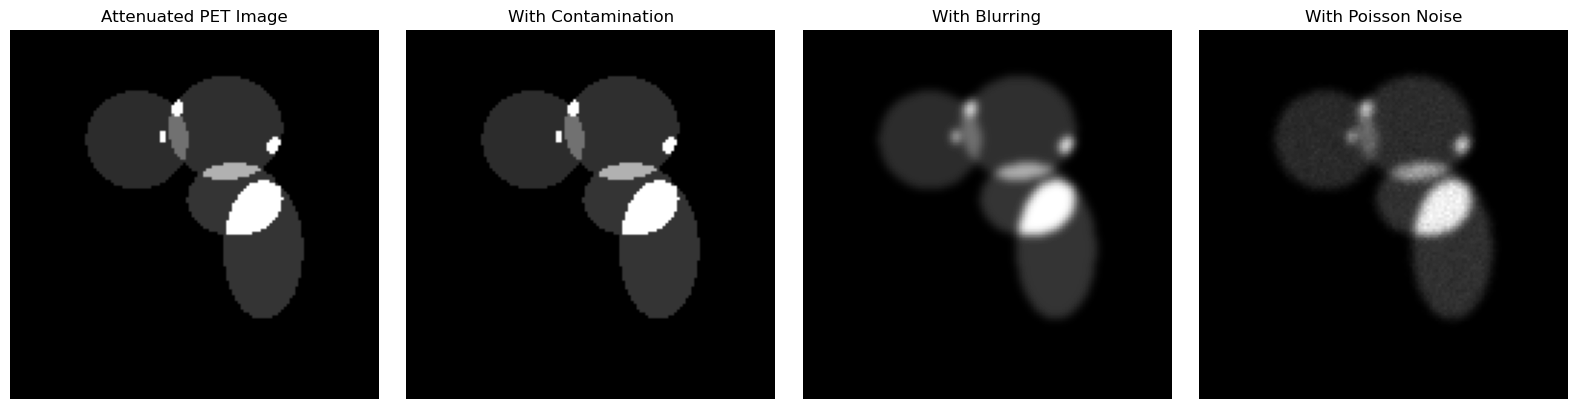

In [ ]:
# Apply contamination

contaminated_pet = add_contamination(attenuated_pet, contamination_factor=0.1)
contaminated_pet = normalize(contaminated_pet)
# Apply Gaussian blurring
blurred_pet = apply_blurring(contaminated_pet, sigma=1.5)
blurred_pet = normalize(blurred_pet)
# Apply Poisson noise
noisy_pet = add_poisson_noise(blurred_pet, scale_factor=1000)
noisy_pet = normalize(noisy_pet)
noisy_ct = add_poisson_noise_ct(ct_image,scale_factor=5000)
noisy_ct = normalize(noisy_ct)


fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(attenuated_pet.cpu().numpy(), cmap="gray")
axes[0].set_title("Attenuated PET Image")

axes[1].imshow(contaminated_pet.cpu().numpy(), cmap="gray")
axes[1].set_title("With Contamination")

axes[2].imshow(blurred_pet.cpu().numpy(), cmap="gray")
axes[2].set_title("With Blurring")

axes[3].imshow(noisy_pet.cpu().numpy(), cmap="gray")
axes[3].set_title("With Poisson Noise")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()



In [28]:
# Parameters 
num_samples = 5000
img_size = (128, 128)
detector_bins = 128
total_counts = 1e6  #Adjust to simulate realistic counts

r = np.linspace(-1, 1, img_size[0])
theta = np.linspace(0, np.pi, detector_bins, endpoint=False)  #Projection angles

#Projection Operator 
proj = parallelproj.ParallelViewProjector2D(
    (detector_bins, detector_bins), r, -theta,
    2 * float(np.max(r)), (float(np.min(r)), float(np.min(r))),
    (float(r[1] - r[0]), float(r[1] - r[0]))
)




In [31]:
# Dataset 
class PETCTDataset(Dataset):
    def __init__(self, num_samples=num_samples, img_size=img_size):
        self.num_samples = num_samples
        self.img_size = img_size
        self.pet_images = []
        self.ct_images = []
        self.pet_projections_clean = []  
        self.ct_projections_clean = []
        self.processed_pet_projections = []  # Store processed PET projections
        self.processed_ct_projections = []  # Store noisy CT projections
     

        for _ in range(num_samples):
            ct_image, ct_segmentation = generate_anatomy(self.img_size, num_ellipsoids=4, min_dist=0.3)
            ct_projection = proj(ct_image)
            ct_projection = normalize(ct_projection)
            
            pet_image, pet_segmentation = generate_pet_image(ct_image, ct_segmentation, num_tumors=3)
            pet_image = normalize(pet_image)  # Normalize PET image
    
            # Generate attenuation map
            attenuation_map = generate_attenuation_map(ct_image, ct_segmentation)
            attenuation_map = normalize(attenuation_map)  # Normalize attenuation map

            # Apply stronger attenuation only to non-tumor regions
            stronger_attenuation_map = torch.exp( -2*attenuation_map * ct_image)
            tumor_mask = (pet_segmentation == 99)  
            attenuated_pet = torch.where(tumor_mask, pet_image, pet_image * stronger_attenuation_map)

            pet_projection = proj(attenuated_pet)
            pet_projection = normalize(pet_projection)
            
            contaminated_pet = add_contamination(pet_projection, contamination_factor=0.1)
            blurred_pet = apply_blurring(contaminated_pet, sigma=1.5)
            noisy_pet = add_poisson_noise(blurred_pet, scale_factor=1000)
            noisy_ct = add_poisson_noise_ct(ct_projection,scale_factor=5000)
            
            
            noisy_pet_sino = normalize(noisy_pet)
            noisy_ct_sino = normalize(noisy_ct)

            # Store results
            self.pet_images.append(attenuated_pet)
            self.ct_images.append(ct_image)
            self.pet_projections_clean.append(torch.tensor(pet_projection, dtype=torch.float32, device=device))
            self.ct_projections_clean.append(torch.tensor(ct_projection, dtype=torch.float32, device=device))
            self.processed_pet_projections.append(noisy_pet_sino.clone().detach())
            self.processed_ct_projections.append(noisy_ct_sino.clone().detach())


    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return (
            self.pet_images[idx],              
            self.ct_images[idx],                   
            self.processed_pet_projections[idx],   
            self.processed_ct_projections[idx],  
            self.pet_projections_clean[idx],       
            self.ct_projections_clean[idx],        
            
        )

#Create Dataset and DataLoader
set_random_seed(1)
dataset = PETCTDataset(num_samples=5) # Set the sample size 
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)



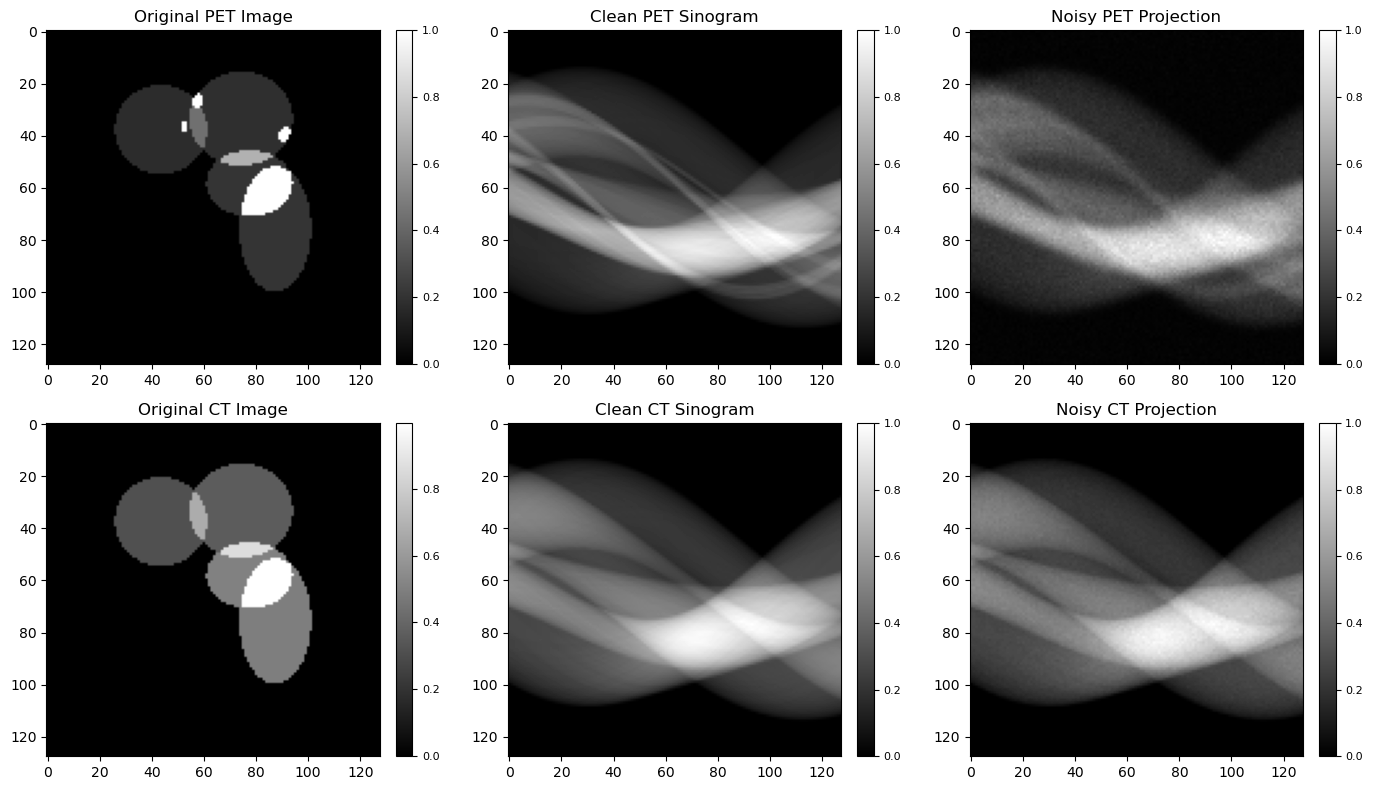

In [32]:
# visualize first sample 
pet_sample, ct_sample, processed_pet, processed_ct, pet_sinogram_clean, ct_sinogram_clean = dataset[0]

fig, ax = plt.subplots(2, 3, figsize=(14, 8))

# Function to add colorbar
def add_colorbar(im, ax):
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  # Adjust colorbar font size if needed

# PET
im0 = ax[0, 0].imshow(pet_sample.cpu().numpy(), cmap="gray")
ax[0, 0].set_title("Original PET Image")
add_colorbar(im0, ax[0, 0])
im1 = ax[0, 1].imshow(pet_sinogram_clean.cpu().numpy(), cmap="gray")
ax[0, 1].set_title("Clean PET Sinogram") 
add_colorbar(im1, ax[0, 1])
im2 = ax[0, 2].imshow(processed_pet.cpu().numpy(), cmap="gray")
ax[0, 2].set_title("Noisy PET Projection") 
add_colorbar(im2, ax[0, 2])

# CT
im3 = ax[1, 0].imshow(ct_sample.cpu().numpy(), cmap="gray")
ax[1, 0].set_title("Original CT Image")
add_colorbar(im3, ax[1, 0])
im4 = ax[1, 1].imshow(ct_sinogram_clean.cpu().numpy(), cmap="gray")
ax[1, 1].set_title("Clean CT Sinogram")
add_colorbar(im4, ax[1, 1])
im5 = ax[1, 2].imshow(processed_ct.cpu().numpy(), cmap="gray")
ax[1, 2].set_title("Noisy CT Projection")
add_colorbar(im5, ax[1, 2])

plt.tight_layout()
plt.show()


